<a href="https://colab.research.google.com/github/YamenObeidat/Machine-Learning-Final-Project-1/blob/main/edit7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data Understanding & Preprocessing**

In [118]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import xgboost as xgb


from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, ConfusionMatrixDisplay,
    precision_recall_curve, roc_curve, RocCurveDisplay, classification_report
)
from xgboost import plot_importance

from sklearn import datasets
from sklearn import svm
from sklearn import datasets as sk_datasets

In [83]:


drive.mount('/content/drive')
!unzip "/content/drive/MyDrive/orders.csv.zip" -d /content/
!unzip "/content/drive/MyDrive/order_products__prior.csv.zip" -d /content/
!unzip "/content/drive/MyDrive/order_products__train.csv.zip" -d /content/
!unzip "/content/drive/MyDrive/products.csv.zip" -d /content/

path1 = '/content/drive/MyDrive/' # for the csv files
path2 = '/content/' # for the zip files
def reduce_mem(df):
    for col in df.columns:
        if df[col].dtype == 'int64':
            df[col] = pd.to_numeric(df[col], downcast='integer')
        elif df[col].dtype == 'float64':
            df[col] = pd.to_numeric(df[col], downcast='float')
    return df

aisles = reduce_mem(pd.read_csv(path1 + 'aisles.csv'))
departments = reduce_mem(pd.read_csv(path1 + 'departments.csv'))
products = reduce_mem(pd.read_csv(path2 + 'products.csv'))
'''these two files were so large.
 they took forever to load, so
 i reduced the amount of rows in them. '''
orders = reduce_mem(pd.read_csv(path2 + 'orders.csv' , nrows = 3000000  ))
order_products_prior = reduce_mem(pd.read_csv(path2 + 'order_products__prior.csv'))

order_products_train = reduce_mem(pd.read_csv(path2 + 'order_products__train.csv'))

datasets = {
    "Aisles": aisles,
    "Departments": departments,
    "Products": products,
    "Orders": orders,
    "Prior": order_products_prior,
    "Train": order_products_train
}

for name, df in datasets.items():
    print(f"{name} Columns: {df.columns.tolist()}")

columns = []
for df in datasets.values():
    columns += list(df.columns)

print(f"Number of columns: {len(columns)}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  /content/drive/MyDrive/orders.csv.zip
replace /content/orders.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: no
Archive:  /content/drive/MyDrive/order_products__prior.csv.zip
replace /content/order_products__prior.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: no
Archive:  /content/drive/MyDrive/order_products__train.csv.zip
replace /content/order_products__train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: no
Archive:  /content/drive/MyDrive/products.csv.zip
replace /content/products.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: no
Aisles Columns: ['aisle_id', 'aisle']
Departments Columns: ['department_id', 'department']
Products Columns: ['product_id', 'product_name', 'aisle_id', 'department_id']
Orders Columns: ['order_id', 'user_id', 'eval_set', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order']
Prior Columns: ['order_id', 'product_i

In [84]:
# I merged products, aisles, and departments into a single products_merged table, to link every product ID to its category name.
products_merged = pd.merge(products, aisles, on='aisle_id', how='inner')
products_merged = pd.merge(products_merged, departments, on='department_id', how='inner')
products_merged = products_merged.drop(['aisle_id', 'department_id'], axis=1)
products_merged.head(10)


,product_id,product_name,aisle,department
0,1,Chocolate Sandwich Cookies,cookies cakes,snacks
1,2,All-Seasons Salt,spices seasonings,pantry
2,3,Robust Golden Unsweetened Oolong Tea,tea,beverages
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,frozen meals,frozen
4,5,Green Chile Anytime Sauce,marinades meat preparation,pantry
5,6,Dry Nose Oil,cold flu allergy,personal care
6,7,Pure Coconut Water With Orange,juice nectars,beverages
7,8,Cut Russet Potatoes Steam N' Mash,frozen produce,frozen
8,9,Light Strawberry Blueberry Yogurt,yogurt,dairy eggs
9,10,Sparkling Orange Juice & Prickly Pear Beverage,water seltzer sparkling water,beverages


In [85]:
print(orders.isnull().sum())

''' Essentially, the sample contains
206,209 unique customers. the reason this column has more than 206K
missing values is because they are each time a unique customer made
the first purchase. (no previous purchases exist if its the first purchase).
If we ignore the first purchase then: '''

avg_days = orders[orders['order_number'] > 1]['days_since_prior_order'].mean()
print(f"Average days between orders: {avg_days : .2f} days")


order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    181005
dtype: int64
Average days between orders:  11.12 days


In [86]:
# First we replace missing values with 0 :
orders['days_since_prior_order'] = orders['days_since_prior_order'].fillna(0)
print(f"Remaining missing values: {orders["days_since_prior_order"].isnull().sum()}")


Remaining missing values: 0


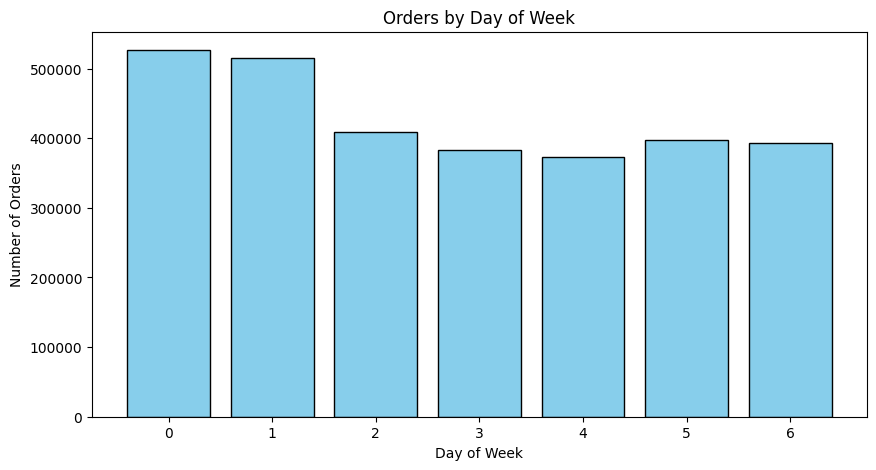

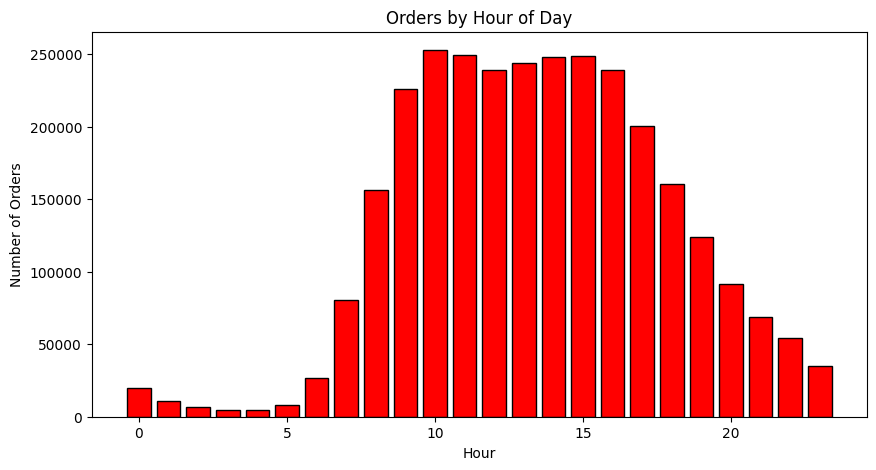

In [87]:
plt.figure(figsize=(10, 5))
day_counts = orders['order_dow'].value_counts().sort_index()
plt.bar(day_counts.index, day_counts.values, color='skyblue', edgecolor='black')
plt.title('Orders by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Orders')
plt.show()

plt.figure(figsize=(10, 5))
hour_counts = orders['order_hour_of_day'].value_counts().sort_index()
plt.bar(hour_counts.index, hour_counts.values, color='red', edgecolor='black')
plt.title('Orders by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Number of Orders')
plt.show()

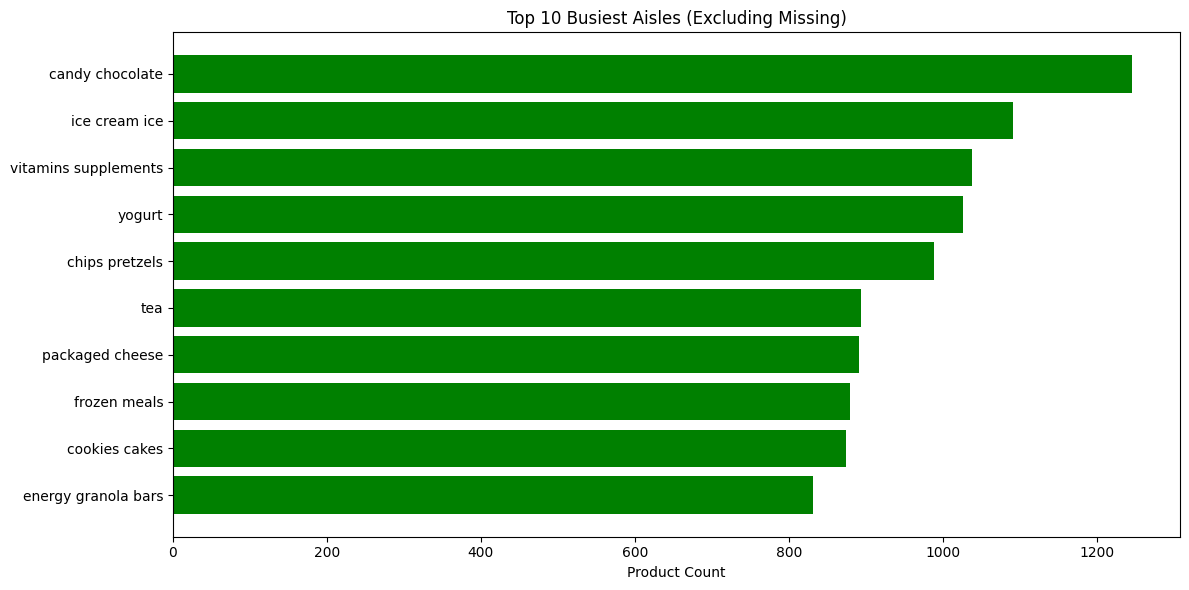

In [88]:
top_aisles = products_merged[products_merged['aisle'] != 'missing']['aisle'].value_counts().head(10)

plt.figure(figsize=(12, 6))
plt.barh(top_aisles.index, top_aisles.values, color='green')
plt.gca().invert_yaxis()
plt.title('Top 10 Busiest Aisles (Excluding Missing)')
plt.xlabel('Product Count')
plt.tight_layout()
plt.show()

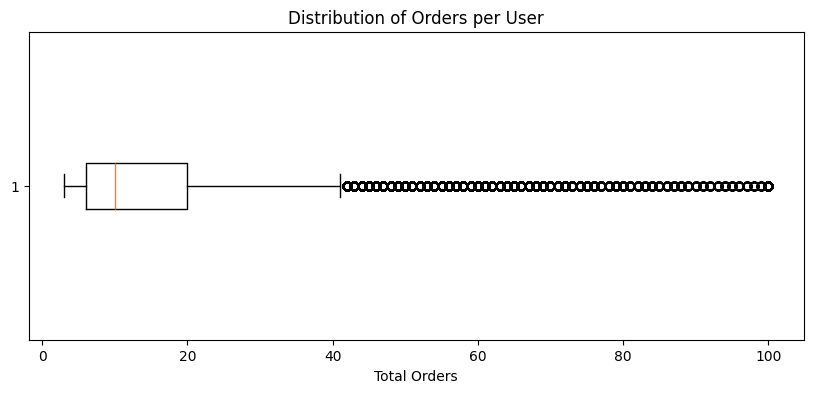

Outlier threshold: 41.0
Total outlier users: 14904


In [89]:
user_orders = orders.groupby('user_id')['order_number'].max()

plt.figure(figsize=(10, 4))
plt.boxplot(user_orders, vert=False)
plt.title('Distribution of Orders per User')
plt.xlabel('Total Orders')
plt.show()

Q1 = user_orders.quantile(0.25)
Q3 = user_orders.quantile(0.75)
IQR = Q3 - Q1
upper_limit = Q3 + 1.5 * IQR

print(f"Outlier threshold: {upper_limit}")
print(f"Total outlier users: {len(user_orders[user_orders > upper_limit])}")

**-----*Feature* *Engineering* & *Representation*-----**

In [90]:
#  max هون عملت تجميع الطلبات لكل مستخدم وبما انه الطلبات مرتبه اخذت
#حسبت حجم كل سله وربطته بالمستخدم
#اخذت المتوسط الحسابي لاحجام السله


user_features = orders.groupby('user_id')['order_number'].max().reset_index()
user_features.columns = ['user_id', 'user_total_orders']

order_sizes = order_products_prior.groupby('order_id').size().reset_index(name='basket_size')
order_sizes = pd.merge(order_sizes, orders[['order_id', 'user_id']], on='order_id')

user_basket_avg = order_sizes.groupby('user_id')['basket_size'].mean().reset_index()
user_basket_avg.columns = ['user_id', 'user_avg_basket_size']
#------------------------------------------------------------------------------------------------------------------------
#ربطت المتجات بالمستخدمين
user_reorder_ratio = pd.merge(order_products_prior, orders[['order_id', 'user_id']], on='order_id')
# حسبت نسبه اعاده الشراء عشان اعرف نسبه ولاء العميل
user_reorder_stats = user_reorder_ratio.groupby('user_id')['reordered'].mean().reset_index()
user_reorder_stats.columns = ['user_id', 'user_reorder_ratio']
#-------------------------------------------------------------------------------------------------------------------------
#حسبت اكثر يوم تكرار عشان اقدر اعتبره اليوم المفضل للتسوق لكل مستخدم ممكن استخدمها بالخصومات او اعلانات بهاض اليوم
user_fav_day = orders.groupby('user_id')['order_dow'].agg(lambda x: x.value_counts().index[0]).reset_index()
user_fav_day.columns = ['user_id', 'user_favorite_dow']

user_df = pd.merge(user_features, user_basket_avg, on='user_id', how='left')
user_df = pd.merge(user_df, user_reorder_stats, on='user_id', how='left')
user_df = pd.merge(user_df, user_fav_day, on='user_id', how='left')

print(user_df.head(9))

   user_id  user_total_orders  user_avg_basket_size  user_reorder_ratio  \
0        1                 11              5.900000            0.694915   
1        2                 15             13.928571            0.476923   
2        3                 13              7.333333            0.625000   
3        4                  6              3.600000            0.055556   
4        5                  5              9.250000            0.378378   
5        6                  4              4.666667            0.142857   
6        7                 21             10.300000            0.669903   
7        8                  4             16.333333            0.265306   
8        9                  4             25.333333            0.236842   

   user_favorite_dow  
0                  4  
1                  1  
2                  0  
3                  4  
4                  3  
5                  5  
6                  0  
7                  1  
8                  1  


In [91]:
#حولت القيم ال (nan)
#لصفر عشان تكون منطقيه اكثر

user_df['user_avg_basket_size'] = user_df['user_avg_basket_size'].fillna(0)
user_df['user_reorder_ratio'] = user_df['user_reorder_ratio'].fillna(0)

print(user_df[['user_avg_basket_size', 'user_reorder_ratio']].isnull().sum())

print(user_df.head(9))

user_avg_basket_size    0
user_reorder_ratio      0
dtype: int64
   user_id  user_total_orders  user_avg_basket_size  user_reorder_ratio  \
0        1                 11              5.900000            0.694915   
1        2                 15             13.928571            0.476923   
2        3                 13              7.333333            0.625000   
3        4                  6              3.600000            0.055556   
4        5                  5              9.250000            0.378378   
5        6                  4              4.666667            0.142857   
6        7                 21             10.300000            0.669903   
7        8                  4             16.333333            0.265306   
8        9                  4             25.333333            0.236842   

   user_favorite_dow  
0                  4  
1                  1  
2                  0  
3                  4  
4                  3  
5                  5  
6                  0  


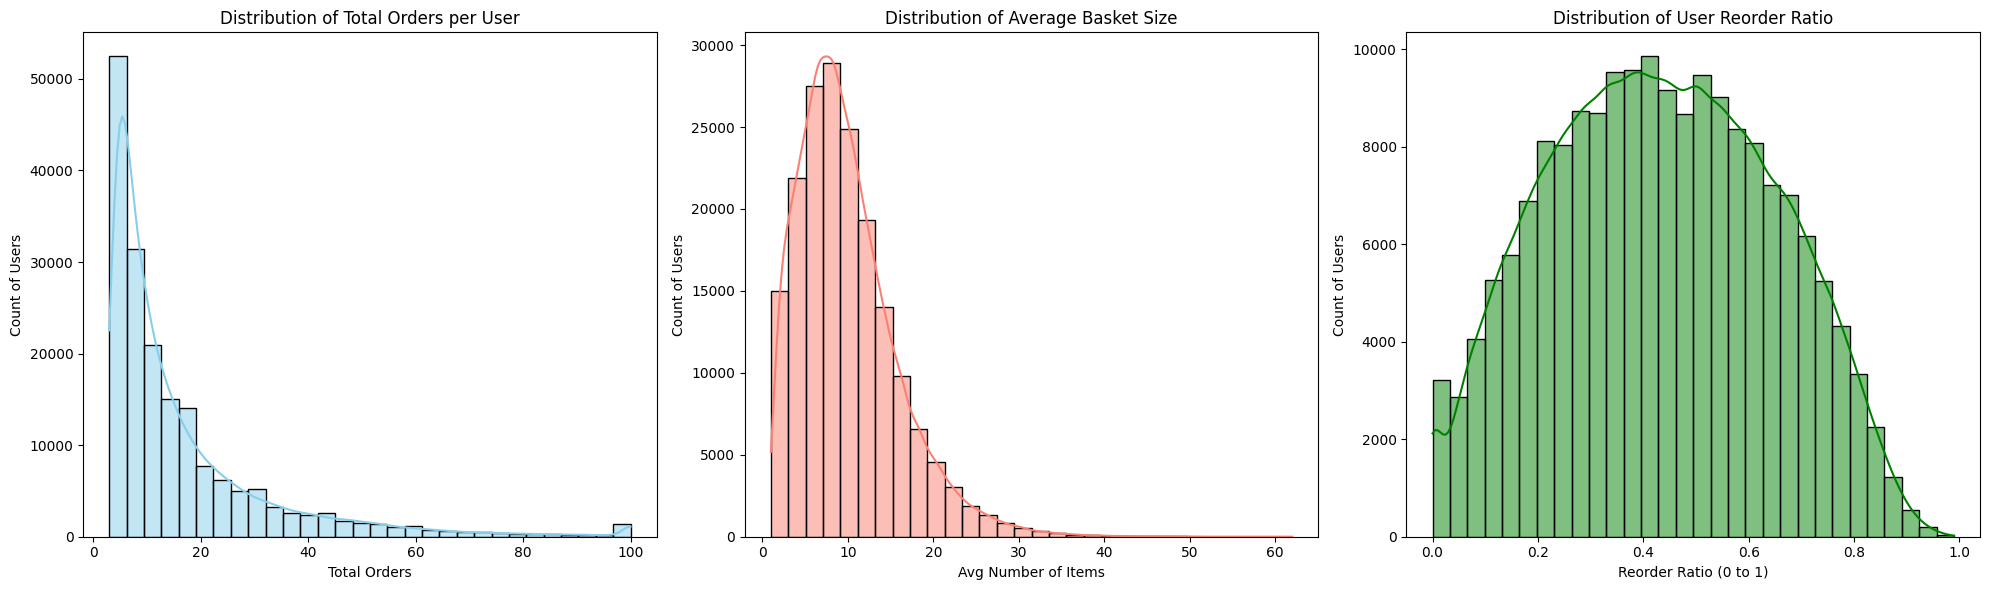

/tmp/ipython-input-4276301451.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='user_favorite_dow', data=user_df, palette='viridis')


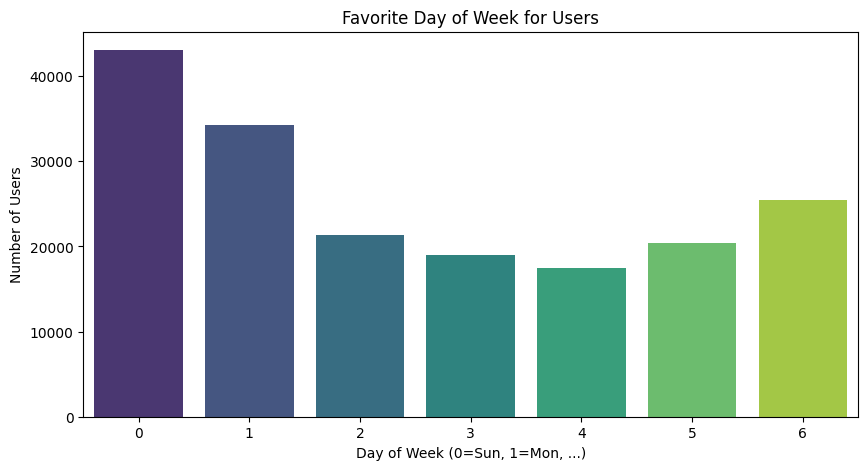

In [92]:
# هون جهزت شكل الرسمة وقسمتها ل 3 أجزاء بصف واحد عشان أقارن التوزيعات مع بعض
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

#  رسمت توزيع  الطلبات عشان أشوف هل أغلب المستخدمين جداد ولا قدام وعندهم طلبات كثير ولا لا
sns.histplot(user_df['user_total_orders'], bins=30, kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Distribution of Total Orders per User')
axes[0].set_xlabel('Total Orders')
axes[0].set_ylabel('Count of Users')

# هون بشوف حجم السلة المعتاد، يعني بالعربي الناس كم قطعة بتحط في كيس التسوق بالمتوسط
sns.histplot(user_df['user_avg_basket_size'], bins=30, kde=True, ax=axes[1], color='salmon')
axes[1].set_title('Distribution of Average Basket Size')
axes[1].set_xlabel('Avg Number of Items')
axes[1].set_ylabel('Count of Users')

# حسبت توزيع نسبة إعادة الشراء عشان أعرف هل العملاء بكرروا نفس المنتجات ولا كل مرة بيجربوا اشي جديد
sns.histplot(user_df['user_reorder_ratio'], bins=30, kde=True, ax=axes[2], color='green')
axes[2].set_title('Distribution of User Reorder Ratio')
axes[2].set_xlabel('Reorder Ratio (0 to 1)')
axes[2].set_ylabel('Count of Users')

plt.tight_layout()
plt.show()

# عملت رسمة للأيام عشان أكشف شو هو اليوم المميز للتسوق عند أغلب المستخدمين عشان ممكن استخدمهم بالنسويق
plt.figure(figsize=(10, 5))
sns.countplot(x='user_favorite_dow', data=user_df, palette='viridis')
plt.title('Favorite Day of Week for Users')
plt.xlabel('Day of Week (0=Sun, 1=Mon, ...)')
plt.ylabel('Number of Users')
plt.show()

In [93]:
# معدل إعادة الطلب الإجمالي للمنتج (Overall Product Reorder Rate)
# هون بحسب كل منتج شو احتمالية إنو الناس ترجع تشتريه مرة ثانية. المنتج اللي نسبته عالية بكون أساسي بالبيت
product_reorder_rate = order_products_prior.groupby('product_id')['reordered'].mean().reset_index()
product_reorder_rate.columns = ['product_id', 'p_reorder_rate']

# متوسط ترتيب المنتج في السلة (Average Position in Cart)
# الميزة هاي كويسة بتكشف إذا المنتج هو أول اشي بيفكر فيه العميل (بكون ترتيبه 1 أو 2) أو هو تكملة عدد بينحط بآخر السلة
product_pos_cart = order_products_prior.groupby('product_id')['add_to_cart_order'].mean().reset_index()
product_pos_cart.columns = ['product_id', 'p_avg_cart_position']

product_popularity = order_products_prior.groupby('product_id').size().reset_index(name='p_total_orders')

# هون دمجت كل المعلومات اللي طلعتها مع جدول المنتجات الأصلي عشان أربط الأرقام بأسماء المنتجات وأقسامها
product_features = pd.merge(products_merged, product_reorder_rate, on='product_id', how='left')
product_features = pd.merge(product_features, product_pos_cart, on='product_id', how='left')
product_features = pd.merge(product_features, product_popularity, on='product_id', how='left')

# تنظيف البيانات: لو في منتج ولا مرة انطلب، بحط مكانه 0 بدل ما تضل الخانة فاضية وتخرب حسابات الموديل بعدين
product_features[['p_reorder_rate', 'p_avg_cart_position', 'p_total_orders']] = product_features[['p_reorder_rate', 'p_avg_cart_position', 'p_total_orders']].fillna(0)

print(product_features.head())

   product_id                                       product_name  \
0           1                         Chocolate Sandwich Cookies   
1           2                                   All-Seasons Salt   
2           3               Robust Golden Unsweetened Oolong Tea   
3           4  Smart Ones Classic Favorites Mini Rigatoni Wit...   
4           5                          Green Chile Anytime Sauce   

                        aisle department  p_reorder_rate  p_avg_cart_position  \
0               cookies cakes     snacks        0.613391             5.801836   
1           spices seasonings     pantry        0.133333             9.888889   
2                         tea  beverages        0.732852             6.415162   
3                frozen meals     frozen        0.446809             9.507599   
4  marinades meat preparation     pantry        0.600000             6.466667   

   p_total_orders  
0          1852.0  
1            90.0  
2           277.0  
3           329.0  
4   

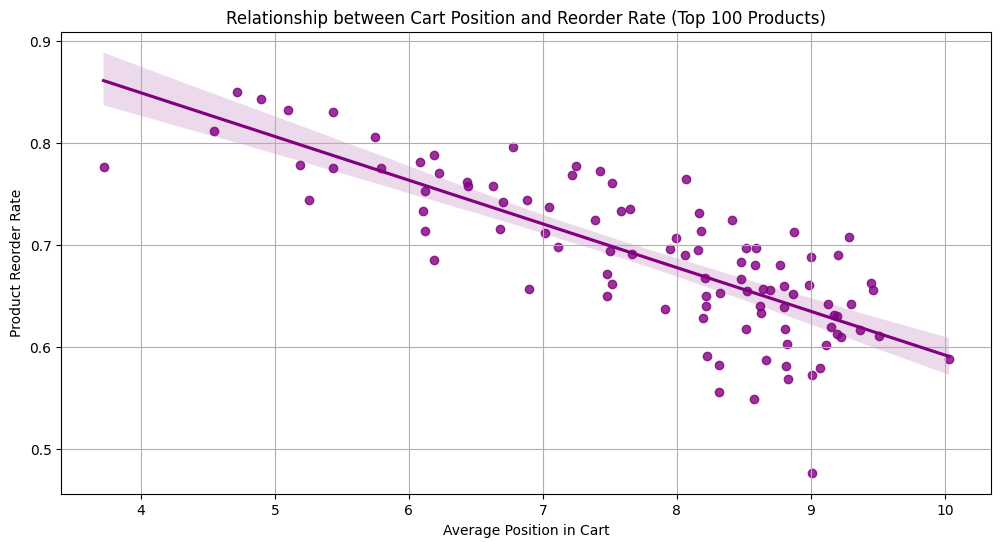

In [94]:
plt.figure(figsize=(12, 6))

#  اخترت أكبر 100 منتج عليهم طلب عشان الرسمة ما تطلع "عجقة" وتكون النتائج منطقية ومبنية على بيانات قوية
top_products = product_features.nlargest(100, 'p_total_orders')

#  رسمت العلاقة بين "ترتيب المنتج بالسلة" و "نسبة إعادة الشراء"
#  رح يورجينا هل في علاقة قوية بينهم ولا لا
sns.regplot(x='p_avg_cart_position', y='p_reorder_rate', data=top_products, color='purple')


plt.title('Relationship between Cart Position and Reorder Rate (Top 100 Products)')
plt.xlabel('Average Position in Cart')
plt.ylabel('Product Reorder Rate')
plt.grid(True)
plt.show()

In [95]:
#  هون بحسب "العلاقة الخاصة" بين كل مستخدم ومنتج
# كم مرة هاض العميل اشترى هاض المنتج بالذات؟ واذا برجع بكررو
user_product_interaction = order_products_prior.merge(orders[['order_id', 'user_id', 'days_since_prior_order']], on='order_id')

up_features = user_product_interaction.groupby(['user_id', 'product_id']).agg(
    up_purchase_count=('order_id', 'count'), # عدد مرات شراء المستخدم لهاد المنتج
    up_reorder_ratio=('reordered', 'mean')   # احتمالية إن العميل يرجع يطلب هاد المنتج بالذات
).reset_index()

#   كم صار له العميل ما اشترى هاض المنتج؟
# هاي الميزة بتعرفنا إذا المنتج خلص من عند الزبون ولازم نذكره فيه
user_product_interaction = user_product_interaction.sort_values(['user_id', 'order_id'])

# جبت رقم آخر طلب عمله كل مستخدم ورقم الطلب اللي اشترى فيه المنتج لآخر مرة
last_order_number = orders.groupby('user_id')['order_number'].max().reset_index()
last_purchase_order = user_product_interaction.groupby(['user_id', 'product_id'])['order_id'].max().reset_index()

# دمجت البيانات عشان أحسب الفرق بين رقم آخر طلب كلي و رقم طلب المنتج"
last_purchase_order = last_purchase_order.merge(orders[['order_id', 'order_number']], on='order_id')
last_purchase_order = last_purchase_order.merge(orders.groupby('user_id')['order_number'].max().reset_index(name='max_order_num'), on='user_id')

# المعادلة هاي بتعطينا عدد الطلبات اللي مرت والمنتج غايب عن السلة
last_purchase_order['up_orders_since_last'] = last_purchase_order['max_order_num'] - last_purchase_order['order_number']
up_features = up_features.merge(last_purchase_order[['user_id', 'product_id', 'up_orders_since_last']], on=['user_id', 'product_id'], how='left')


print(up_features.head())

   user_id  product_id  up_purchase_count  up_reorder_ratio  \
0        1         196                 10          0.900000   
1        1       10258                  9          0.888889   
2        1       10326                  1          0.000000   
3        1       12427                 10          0.900000   
4        1       13032                  3          0.666667   

   up_orders_since_last  
0                     5  
1                     5  
2                     6  
3                     5  
4                     1  


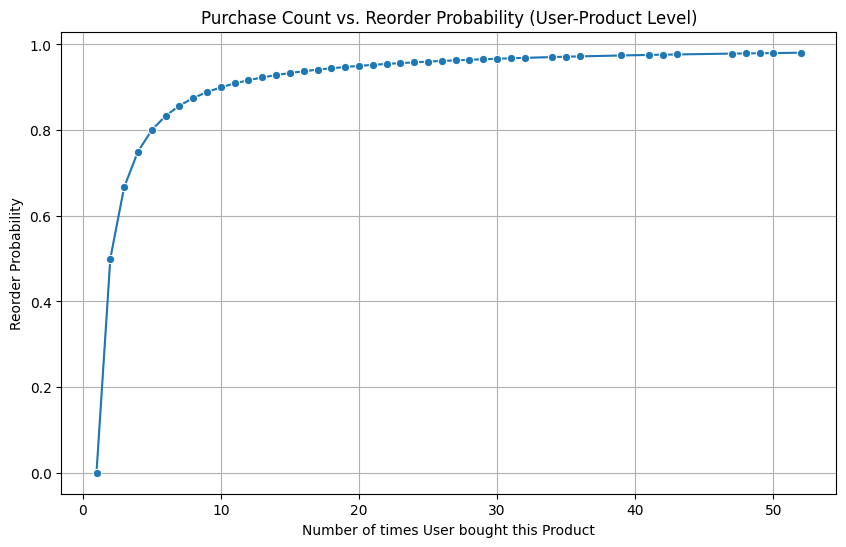

In [96]:
#  العلاقة بين كم مرة اشترى المستخدم هاض المنتج وبين احتمالية إنه يرجع يطلبه
plt.figure(figsize=(10, 6))

sns.lineplot(data=up_features.sample(10000), x='up_purchase_count', y='up_reorder_ratio', marker='o')

plt.title('Purchase Count vs. Reorder Probability (User-Product Level)')
plt.xlabel('Number of times User bought this Product')
plt.ylabel('Reorder Probability')
plt.grid(True)
plt.show()

In [97]:
# استخراج الساعة واليوم (موجودة أصلاً ولكن سنقوم بتنظيمها)
temporal_features = orders[['order_id', 'user_id', 'order_dow', 'order_hour_of_day', 'days_since_prior_order']].copy()

def get_day_part(hour):
    if 5 <= hour < 12: return 'morning'
    elif 12 <= hour < 17: return 'afternoon'
    elif 17 <= hour < 21: return 'evening'
    else: return 'night'

temporal_features['day_part'] = temporal_features['order_hour_of_day'].apply(get_day_part)

temporal_features['is_weekend'] = temporal_features['order_dow'].apply(lambda x: 1 if x in [0, 1] else 0)

temporal_features['cum_days'] = temporal_features.groupby('user_id')['days_since_prior_order'].cumsum()
temporal_features['approx_month'] = (temporal_features['cum_days'] // 30) % 12
temporal_features['season'] = temporal_features['approx_month'].apply(
    lambda x: 'Winter' if x in [11, 0, 1] else
              'Spring' if x in [2, 3, 4] else
              'Summer' if x in [5, 6, 7] else 'Fall'
)

print(temporal_features[['order_id', 'day_part', 'is_weekend', 'season']].head())

   order_id   day_part  is_weekend  season
0   2539329    morning           0  Winter
1   2398795    morning           0  Winter
2    473747  afternoon           0  Winter
3   2254736    morning           0  Spring
4    431534  afternoon           0  Spring


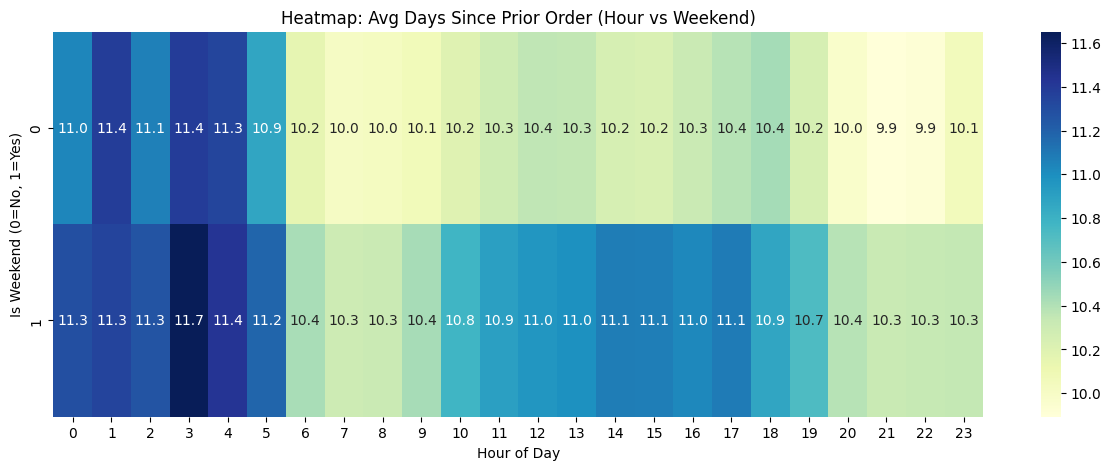

In [98]:
pivot_table = temporal_features.pivot_table(index='is_weekend',
                                            columns='order_hour_of_day',
                                            values='days_since_prior_order',
                                            aggfunc='mean')

plt.figure(figsize=(15, 5))
sns.heatmap(pivot_table, annot=True, fmt=".1f", cmap="YlGnBu")

# هون حطيت العناوين عشان توضح إن اللون الغامق يعني فترة غياب طويلة والفاتح يعني فترة قصيرة
plt.title('Heatmap: Avg Days Since Prior Order (Hour vs Weekend)')
plt.xlabel('Hour of Day')
plt.ylabel('Is Weekend (0=No, 1=Yes)')
plt.show()

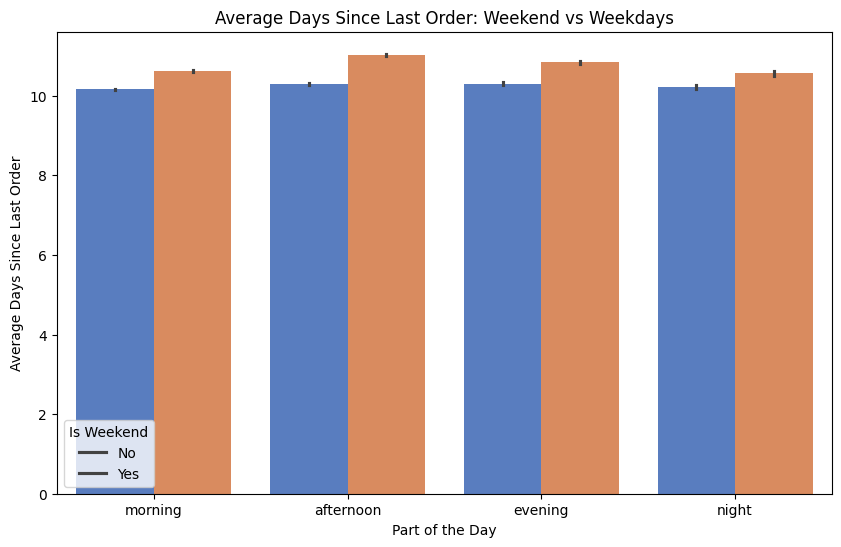

In [99]:
plt.figure(figsize=(10, 6))

# استخدمت الرسم بالأعمدة (barplot) لأنه أبسط اشي للعين
# قارنت بين فترات اليوم مع متوسط الأيام اللي مرت
sns.barplot(data=temporal_features, x='day_part', y='days_since_prior_order', hue='is_weekend', palette='muted')

plt.title('Average Days Since Last Order: Weekend vs Weekdays')
plt.xlabel('Part of the Day')
plt.ylabel('Average Days Since Last Order')
plt.legend(title='Is Weekend', labels=['No', 'Yes'])
plt.show()

In [100]:
data = up_features.copy()

data = data.merge(user_df, on='user_id', how='left')

data = data.merge(product_features, on='product_id', how='left')

last_orders = orders.groupby('user_id')['order_id'].max().reset_index()
last_order_info = temporal_features.merge(last_orders, on=['user_id', 'order_id'])

data = data.merge(last_order_info, on='user_id', how='left')

data = data.fillna(0)

print(f"حجم البيانات الآن: {data.shape}")
print(data.head())

حجم البيانات الآن: (11683090, 24)
   user_id  product_id  up_purchase_count  up_reorder_ratio  \
0        1         196                 10          0.900000   
1        1       10258                  9          0.888889   
2        1       10326                  1          0.000000   
3        1       12427                 10          0.900000   
4        1       13032                  3          0.666667   

   up_orders_since_last  user_total_orders  user_avg_basket_size  \
0                     5                 11                   5.9   
1                     5                 11                   5.9   
2                     6                 11                   5.9   
3                     5                 11                   5.9   
4                     1                 11                   5.9   

   user_reorder_ratio  user_favorite_dow           product_name  ...  \
0            0.694915                  4                   Soda  ...   
1            0.694915             

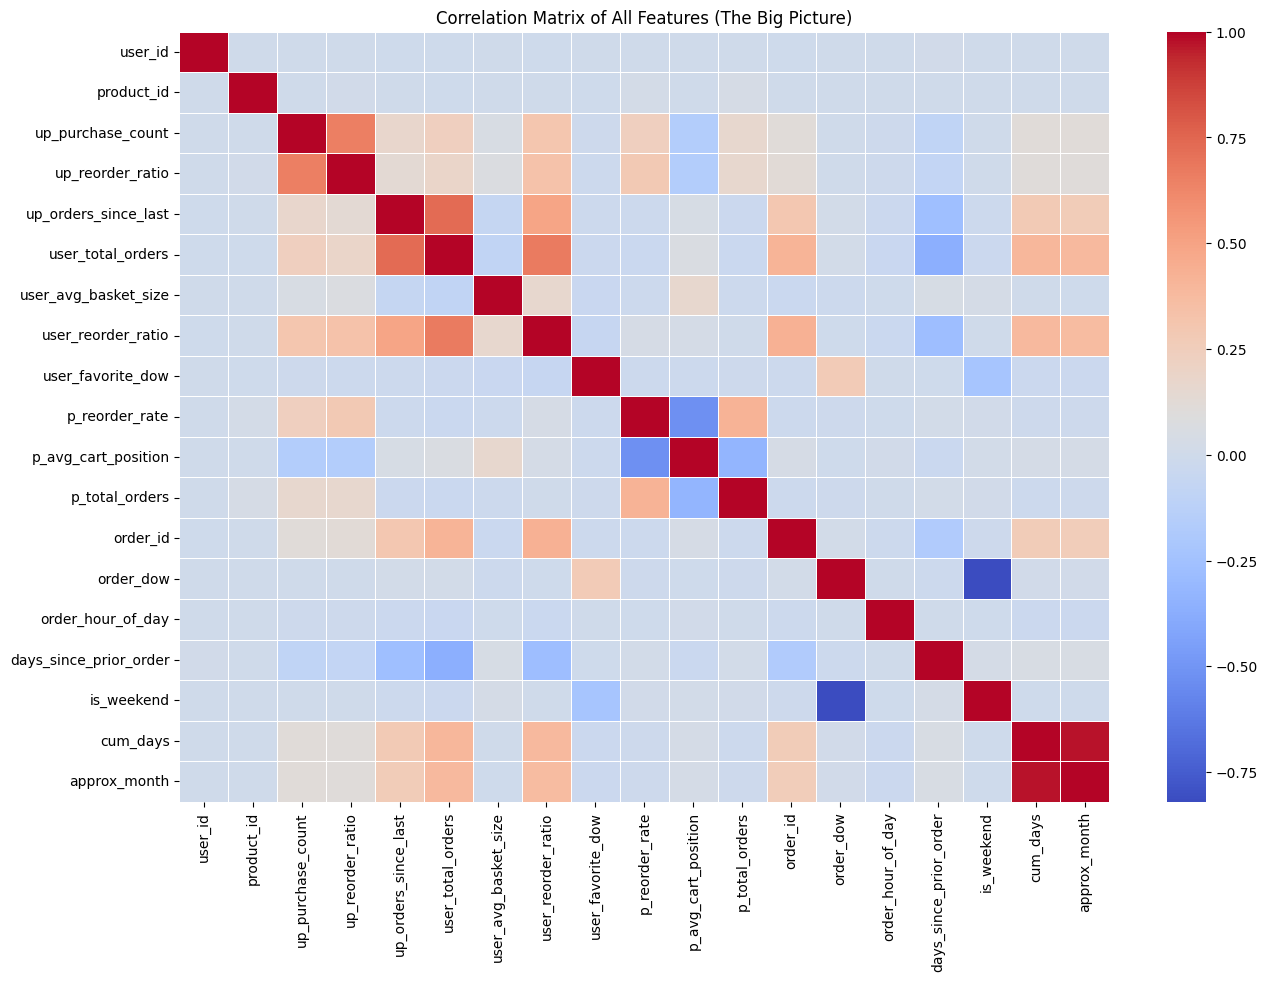

In [101]:
numeric_data = data.select_dtypes(include=[np.number])

corr_matrix = numeric_data.corr()

plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)

plt.title('Correlation Matrix of All Features (The Big Picture)')
plt.show()

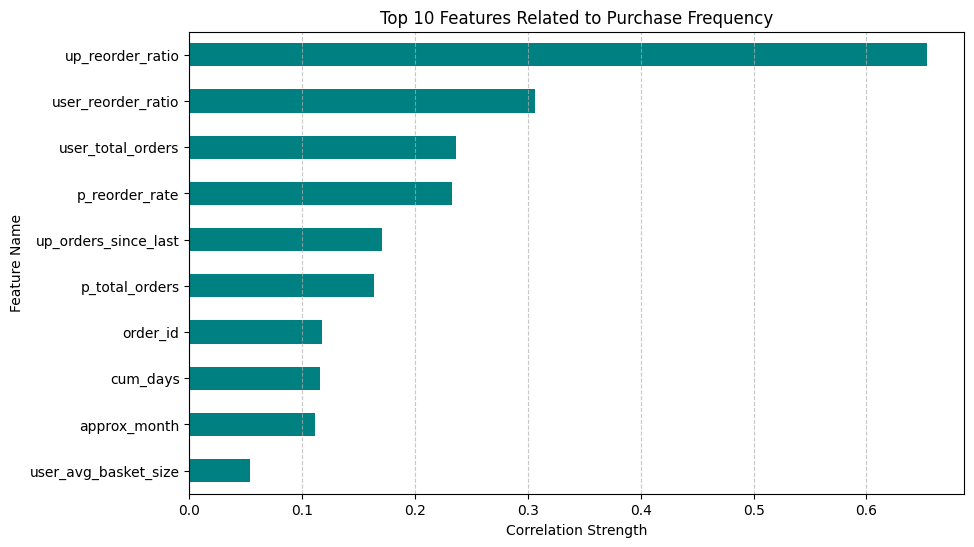

In [102]:
correlations = data.corr(numeric_only=True)['up_purchase_count'].sort_values(ascending=False)

top_features = correlations.drop('up_purchase_count').head(10)

plt.figure(figsize=(10, 6))
top_features.plot(kind='barh', color='teal')

plt.title('Top 10 Features Related to Purchase Frequency')
plt.xlabel('Correlation Strength')
plt.ylabel('Feature Name')
plt.gca().invert_yaxis() # عشان الترتيب يبدأ من الأقوى فوق
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

In [103]:


# بنربطها مع جدول orders عشان نعرف كل (user_id) شو اشترى في آخر طلب
train_data_full = order_products_train.merge(orders[['order_id', 'user_id']], on='order_id', how='left')

# بنعمل عمود الهدف: 1 يعني انطلب
train_data_full['target'] = 1

if 'target' in data.columns:
    data = data.drop('target', axis=1)

data = data.merge(train_data_full[['user_id', 'product_id', 'target']],
                  on=['user_id', 'product_id'],
                  how='left')

data['target'] = data['target'].fillna(0)

print("TARGET:")
print(data['target'].value_counts())

TARGET:
target
0.0    10954332
1.0      728758
Name: count, dtype: int64


/tmp/ipython-input-753541960.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=data['target'], palette='magma')


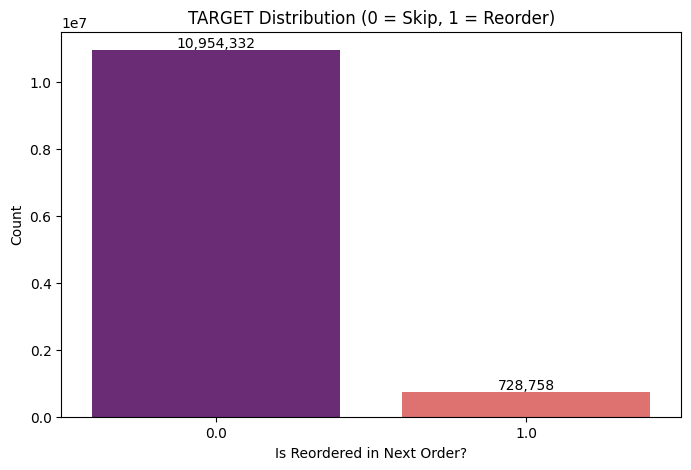

TARGET counts:
target
0.0    10954332
1.0      728758
Name: count, dtype: int64


In [105]:


train_labels = order_products_train.merge(orders[['order_id', 'user_id']], on='order_id')
train_labels['target'] = 1
data = data.drop('target', axis=1)

data = data.merge(train_labels[['user_id', 'product_id', 'target']],
                  on=['user_id', 'product_id'],
                  how='left')

data['target'] = data['target'].fillna(0)

plt.figure(figsize=(8, 5))

sns.countplot(x=data['target'], palette='magma')

plt.title('TARGET Distribution (0 = Skip, 1 = Reorder)')
plt.xlabel('Is Reordered in Next Order?')
plt.ylabel('Count')

counts = data['target'].value_counts().sort_index()
for i, count in enumerate(counts):
    plt.text(i, count, f'{count:,}', ha='center', va='bottom')

plt.show()

print("TARGET counts:")
print(data['target'].value_counts())

# **scaler**

In [106]:
from sklearn.preprocessing import StandardScaler
import gc

cols_to_scale = [
    'up_purchase_count', 'up_reorder_ratio', 'up_orders_since_last',
    'user_total_orders', 'user_avg_days_reorder', 'user_std_days_reorder',
    'user_avg_basket_size', 'user_reorder_ratio', 'total_sales',
    'reorder_rate', 'avg_cart_position'
]

existing_cols = [c for c in cols_to_scale if c in data.columns]

scaler = StandardScaler()
data[existing_cols] = scaler.fit_transform(data[existing_cols])

# Added lines for RAM optimization
data[existing_cols] = data[existing_cols].astype('float32')
gc.collect()

24317

# **TASK A:**

# **Data Cleaning and Transformation**

In [107]:
#هون حذفت الترتيب عشان الموديل مايحفظ انه مثلا مستخدم رقم 5 اشترى منتج رقم 7 بدل ما يفهم ليش
#تجنبا للOverfitting
cols_to_drop = ['user_id', 'product_id', 'order_id', 'target', 'product_name', 'day_part', 'season']
#هون تأكدت من الحذف وضفت اخر نقطه عشان عشان واجهتني مشكله اذا برجع اعيد الcell بعمل ايرر لانه بكون العمود اصلا محذوف هيك صار يتجاهله
data = data.sample(frac=0.1, random_state=42)
X = data.drop(columns=cols_to_drop, errors='ignore')
y = data['target']
#للتاكد من الحذف
X = X.select_dtypes(include=[np.number])
#تقسيم الببيانات اللا اختبار وتدريب

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"الميزات المستخدمة في التدريب: {list(X.columns)}")
print(f"حجم عينة التدريب: {X_train.shape[0]} سطر")

الميزات المستخدمة في التدريب: ['up_purchase_count', 'up_reorder_ratio', 'up_orders_since_last', 'user_total_orders', 'user_avg_basket_size', 'user_reorder_ratio', 'user_favorite_dow', 'p_reorder_rate', 'p_avg_cart_position', 'p_total_orders', 'order_dow', 'order_hour_of_day', 'days_since_prior_order', 'is_weekend', 'cum_days', 'approx_month']
حجم عينة التدريب: 934647 سطر


# **Logistic Regression  :-**





In [108]:

log_reg = LogisticRegression(
    penalty='l2',#عشان اقلل الاوزان الكبيره واتجاهل الميزات الي ما الها لازمه عشان اتجنب الاوفرفتنق
    class_weight='balanced',#عشان اعمل توازن في البيانات لانه بالاغلب المنتجات الي تم اعاده شراها هي الاقل ولو ما حطيت هاي النقطه ال ridge رح يتجاهلها وهي الأهم
    solver='saga',#اخترتها لانها الاسرع وبتدعن ال L1,L2
    max_iter=100,#عدد التكرارات للوصول لافضل اجابه
    n_jobs=-1#استخدم كل طاقع المعالج CPU
)

print("استنى قاعد بتدرب...")
log_reg.fit(X_train, y_train)

y_pred_lr = log_reg.predict(X_test)

print("\n--- Logistic Regression Report ---")
print(classification_report(y_test, y_pred_lr))

استنى قاعد بتدرب...

--- Logistic Regression Report ---
              precision    recall  f1-score   support

         0.0       0.95      0.75      0.84    219184
         1.0       0.09      0.40      0.15     14478

    accuracy                           0.73    233662
   macro avg       0.52      0.57      0.49    233662
weighted avg       0.90      0.73      0.79    233662



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


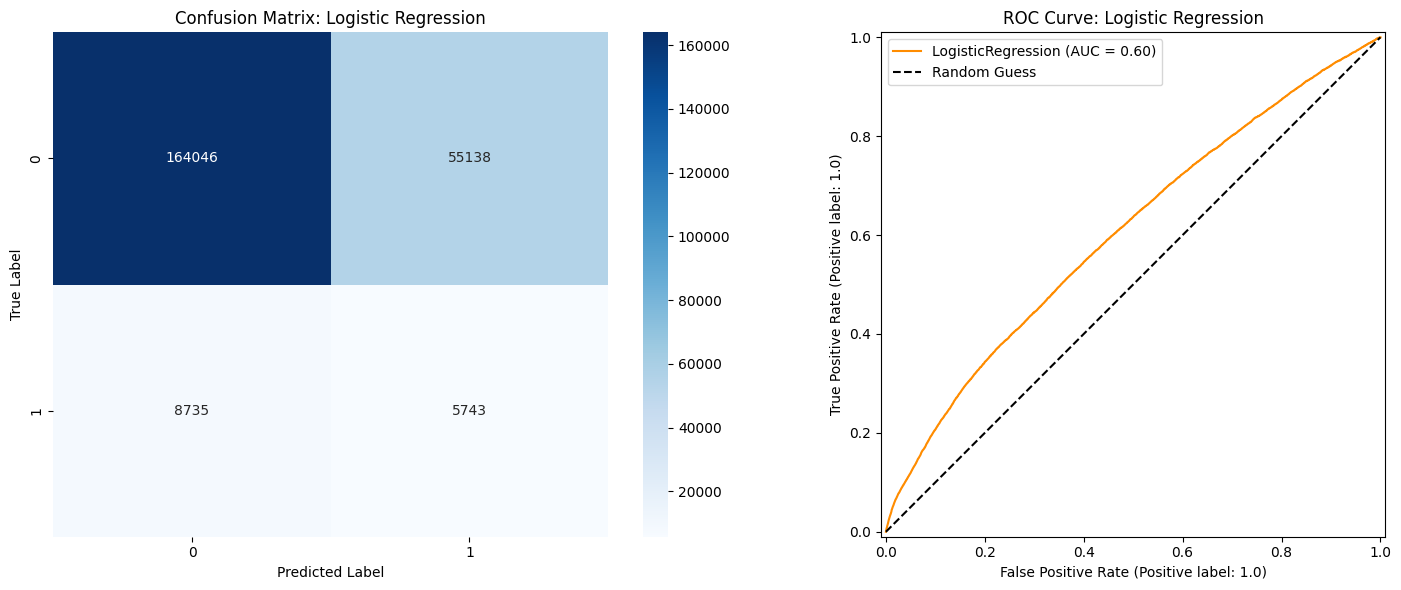

In [109]:


fig, ax = plt.subplots(1, 2, figsize=(15, 6))

cm = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title('Confusion Matrix: Logistic Regression')
ax[0].set_xlabel('Predicted Label')
ax[0].set_ylabel('True Label')

RocCurveDisplay.from_estimator(log_reg, X_test, y_test, ax=ax[1], color='darkorange')
ax[1].plot([0, 1], [0, 1], 'k--', label='Random Guess')
ax[1].set_title('ROC Curve: Logistic Regression')
ax[1].legend()

plt.tight_layout()
plt.show()

In [110]:


y_pred = log_reg.predict(X_test)# Accuracy و Precision و Recall.عشان يعطيني قرار نهائي 0او1 ونستخدمه في حساب
y_probs = log_reg.predict_proba(X_test)[:, 1]#ROC AUCهون رح يعطي نسيه مئويه لحساب

metrics = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1-Score": f1_score(y_test, y_pred),
    "ROC AUC": roc_auc_score(y_test, y_probs)
}

print("--- Logistic Regression Test Results ---")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")



--- Logistic Regression Test Results ---
Accuracy: 0.7266
Precision: 0.0943
Recall: 0.3967
F1-Score: 0.1524
ROC AUC: 0.6040


# **K-Nearest Neighbors classifier**

In [111]:
#هون اخذت عينه من البيانات لانه هاي الخوارزميه تعتبر خوارزميه تعبانه
#لانها ما بتهمل نموذج بتروح تخزن البيانات وبتحسب المسافه بينهم

data_sample = data.sample(20000, random_state=42)#;)

y_sample = data_sample['target']


X_sample = data_sample.select_dtypes(include=['number']).drop(columns=['target', 'user_id', 'product_id', 'order_id'], errors='ignore')

X_train_k, X_test_k, y_train_k, y_test_k = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42)
#استخدمت توحيد المقاييس عشان ما ميزه تطغى على غيرها
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_k)
X_test_scaled = scaler.transform(X_test_k)

knn = KNeighborsClassifier(n_neighbors=5)
print("استنى علي قاعد بتدرب :)")
knn.fit(X_train_scaled, y_train_k)

y_pred_knn = knn.predict(X_test_scaled)



استنى علي قاعد بتدرب :)


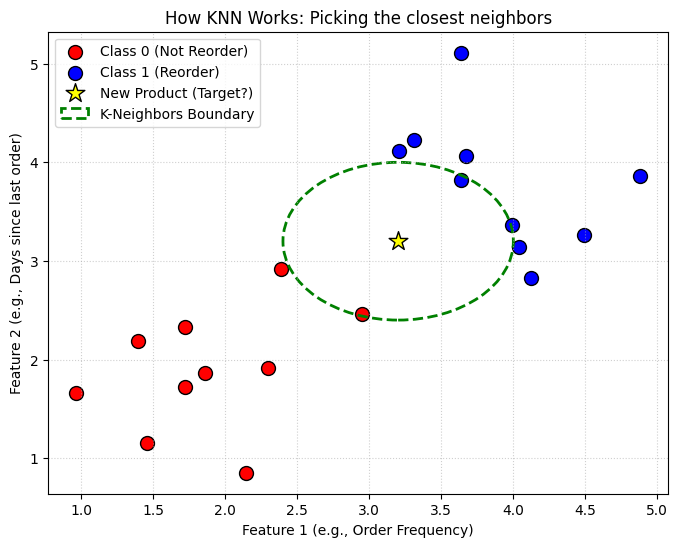

In [112]:


np.random.seed(42)
class_0 = np.random.normal(loc=[2, 2], scale=0.6, size=(10, 2)) # منتجات لن تطلب
class_1 = np.random.normal(loc=[4, 4], scale=0.6, size=(10, 2)) # منتجات ستطلب
new_point = np.array([3.2, 3.2]) # المنتج الجديد اللي بدنا نتوقعه

plt.figure(figsize=(8, 6))
plt.scatter(class_0[:, 0], class_0[:, 1], c='red', label='Class 0 (Not Reorder)', s=100, edgecolors='k')
plt.scatter(class_1[:, 0], class_1[:, 1], c='blue', label='Class 1 (Reorder)', s=100, edgecolors='k')
plt.scatter(new_point[0], new_point[1], c='yellow', label='New Product (Target?)', s=200, marker='*', edgecolors='k')

circle = plt.Circle((3.2, 3.2), 0.8, color='green', fill=False, linestyle='--', linewidth=2, label='K-Neighbors Boundary')
plt.gca().add_artist(circle)

plt.title('How KNN Works: Picking the closest neighbors')
plt.xlabel('Feature 1 (e.g., Order Frequency)')
plt.ylabel('Feature 2 (e.g., Days since last order)')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

In [113]:


acc_knn = accuracy_score(y_test_k, y_pred_knn)
prec_knn = precision_score(y_test_k, y_pred_knn)
rec_knn = recall_score(y_test_k, y_pred_knn)
f1_knn = f1_score(y_test_k, y_pred_knn)

print("KNN:")
print(f"{'Accuracy:':<15} {acc_knn:.2%}")
print(f"{'Precision:':<15} {prec_knn:.2%}")
print(f"{'Recall:':<15} {rec_knn:.2%}")
print(f"{'F1-Score:':<15} {f1_knn:.2%}")

print("\nDetailed Report:")
print(classification_report(y_test_k, y_pred_knn))

KNN:
Accuracy:       93.23%
Precision:      31.82%
Recall:         5.49%
F1-Score:       9.36%

Detailed Report:
              precision    recall  f1-score   support

         0.0       0.94      0.99      0.96      3745
         1.0       0.32      0.05      0.09       255

    accuracy                           0.93      4000
   macro avg       0.63      0.52      0.53      4000
weighted avg       0.90      0.93      0.91      4000



# **Support Vector Machine (linear + kernel )**






In [114]:
#KNNلما اخذت عينه اخدت عينه بسيطه حتى ابسط من
#لانه هون بعمل عمليا حسابيه معقده اكثر ورح يستهلك موارد اكثر وقتها

data_svm = data.sample(5000, random_state=42)
X_svm = data_svm.select_dtypes(include=['number']).drop(columns=['target', 'user_id', 'product_id', 'order_id'], errors='ignore')
y_svm = data_svm['target']

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_svm, y_svm, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_s)
X_test_scaled = scaler.transform(X_test_s)


svm_linear = SVC(kernel='linear', class_weight='balanced')
svm_linear.fit(X_train_scaled, y_train_s)

svm_kernel = SVC(kernel='rbf', class_weight='balanced')
svm_kernel.fit(X_train_scaled, y_train_s)



SVC(class_weight='balanced')

In [115]:


def get_svm_metrics(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    return {
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred)
    }

linear_results = get_svm_metrics(svm_linear, X_test_scaled, y_test_s, 'SVM Linear')
kernel_results = get_svm_metrics(svm_kernel, X_test_scaled, y_test_s, 'SVM Kernel (RBF)')

df_svm_results = pd.DataFrame([linear_results, kernel_results])
print("SVM:")
print(df_svm_results.to_string(index=False))

SVM:
           Model  Accuracy  Precision   Recall  F1-Score
      SVM Linear     0.731   0.120996 0.607143   0.20178
SVM Kernel (RBF)     0.754   0.113821 0.500000   0.18543


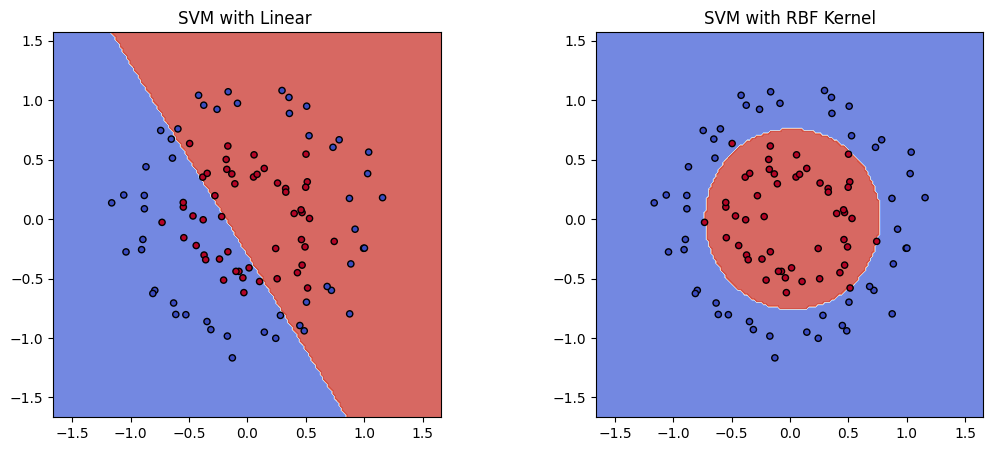

In [119]:

X, y = datasets.make_circles(n_samples=100, factor=0.5, noise=0.1, random_state=42)


models = (svm.SVC(kernel='linear'),
          svm.SVC(kernel='rbf', gamma=0.7))
models = (clf.fit(X, y) for clf in models)


titles = ('SVM with Linear ',
          'SVM with RBF Kernel')

fig, sub = plt.subplots(1, 2, figsize=(12, 5))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

X0, X1 = X[:, 0], X[:, 1]
xx, yy = np.meshgrid(np.arange(X0.min()-0.5, X0.max()+0.5, 0.02),
                     np.arange(X1.min()-0.5, X1.max()+0.5, 0.02))

for clf, title, ax in zip(models, titles, sub.flatten()):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_title(title)

plt.show()

# **Decision Tree classifier**

In [120]:
#max depth =10 اهم نقطه هون انه استخدمت ال
#overfittingتجنبا من

dt_model = DecisionTreeClassifier(max_depth=10, random_state=42, class_weight='balanced')

dt_model.fit(X_train, y_train)

y_pred_dt = dt_model.predict(X_test)

In [121]:
dt_results = {
    'Model': 'Decision Tree',
    'Accuracy': accuracy_score(y_test, y_pred_dt),
    'Precision': precision_score(y_test, y_pred_dt),
    'Recall': recall_score(y_test, y_pred_dt),
    'F1-Score': f1_score(y_test, y_pred_dt)
}

print(dt_results)

{'Model': 'Decision Tree', 'Accuracy': 0.7096404207787317, 'Precision': 0.142564363597396, 'Recall': 0.7351153474236773, 'F1-Score': 0.23881434277251717}


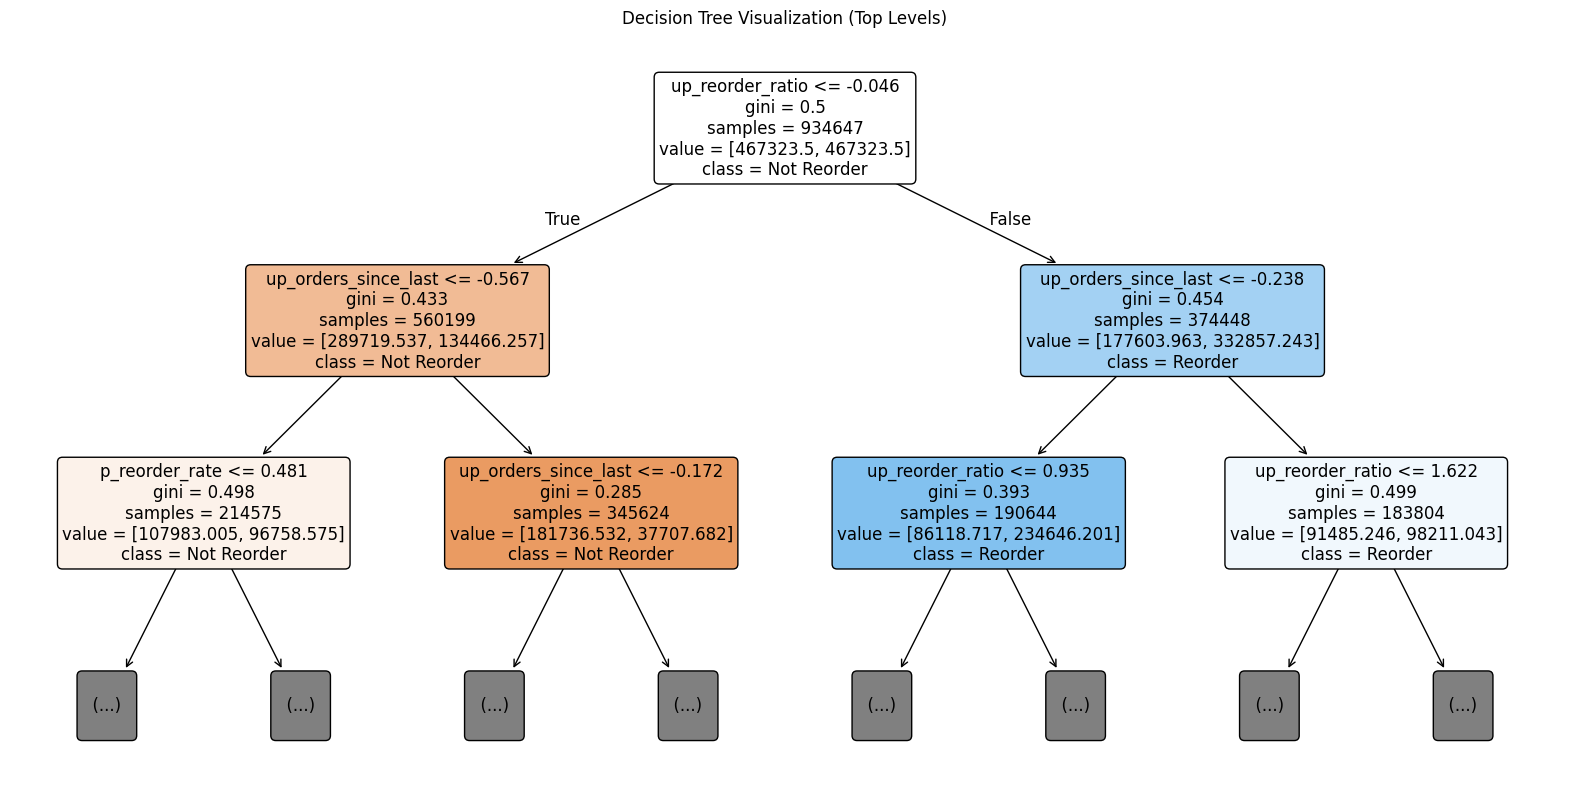

In [122]:


plt.figure(figsize=(20, 10))
plot_tree(dt_model,
          max_depth=2,
          feature_names=X_train.columns,
          class_names=['Not Reorder', 'Reorder'],
          filled=True,
          rounded=True,
          fontsize=12)
plt.title("Decision Tree Visualization (Top Levels)")
plt.show()

/tmp/ipython-input-1226351668.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


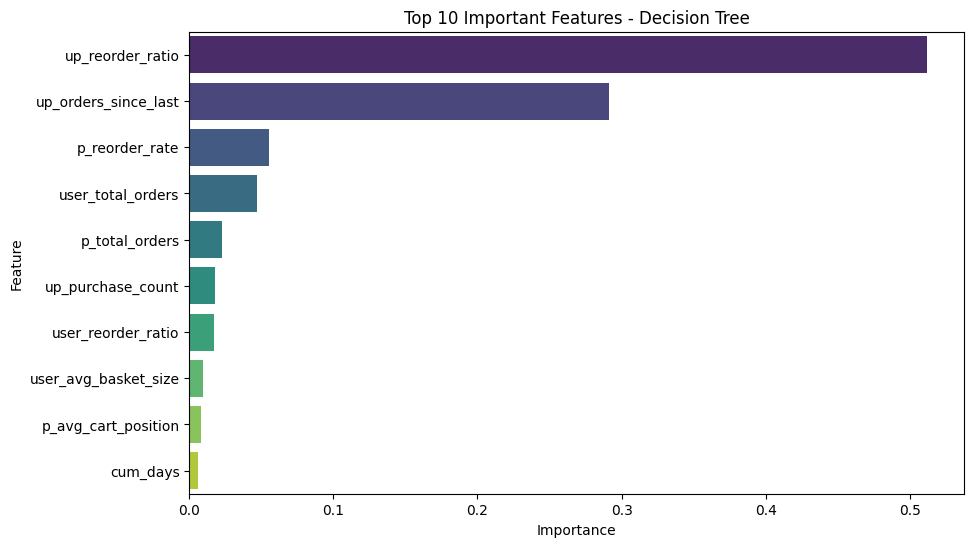

In [123]:

importances = dt_model.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})


feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)


plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Top 10 Important Features - Decision Tree')
plt.show()

# **Random Forest classifier**


In [124]:
# هون اكثر نموذج بغلب وبوخذ وقت
#استخدمت 100 شجره كل وحده بتتعلم من بيانات عشان اقلل نسبه الخطا

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=12,#رفعته شوي اكثر من الطبيعي عشان اسمحله يتعلم تفاصيل اكثر تعقيد
    random_state=42,
    class_weight='balanced',
    n_jobs=-1# سمعت انها كويسه عشان المعالح وبتسرع التدريب كثير
)

rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

In [125]:

rf_results = {
    'Model': 'Random Forest',
    'Accuracy': accuracy_score(y_test, y_pred_rf),
    'Precision': precision_score(y_test, y_pred_rf),
    'Recall': recall_score(y_test, y_pred_rf),
    'F1-Score': f1_score(y_test, y_pred_rf)
}

print("Random Forest:")
print(rf_results)

Random Forest:
{'Model': 'Random Forest', 'Accuracy': 0.7639838741429928, 'Precision': 0.16402868188877506, 'Recall': 0.6857300732145324, 'F1-Score': 0.26473254759746145}


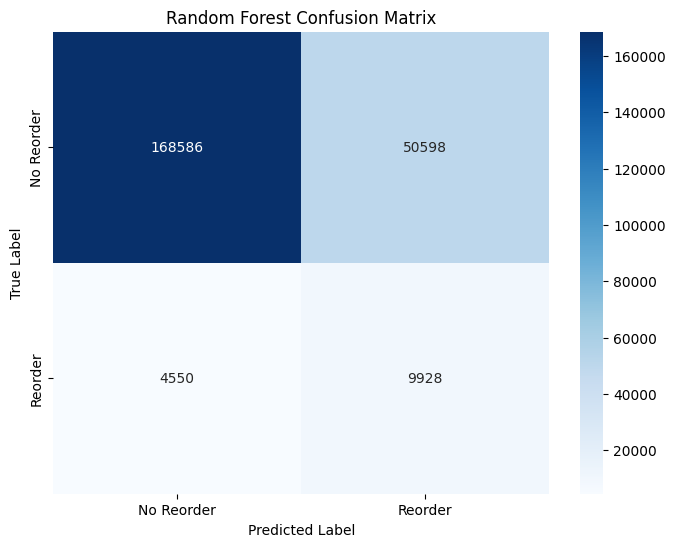

In [126]:
cm = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Reorder', 'Reorder'],
            yticklabels=['No Reorder', 'Reorder'])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Random Forest Confusion Matrix')
plt.show()

# **Gradient boosting classifier (XGBoost / LightGBM) — required**


In [127]:


xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,# بطئت التعلم كل شجره تصحح الي قبلها صح صار اطول بس ادق
    scale_pos_weight=5, # هاي بدل البلنس الي كنت استخدمها بالعاده عشان يعطي اهميه اكبر للفئه المطلوبه
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)


xgb_model.fit(X_train, y_train)


y_pred_xgb = xgb_model.predict(X_test)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [01:54:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [128]:
xgb_results = {
    'Model': 'XGBoost',
    'Accuracy': accuracy_score(y_test, y_pred_xgb),
    'Precision': precision_score(y_test, y_pred_xgb),
    'Recall': recall_score(y_test, y_pred_xgb),
    'F1-Score': f1_score(y_test, y_pred_xgb)
}

print("XGBoost:")
print(xgb_results)

XGBoost:
{'Model': 'XGBoost', 'Accuracy': 0.8934015800600867, 'Precision': 0.2609114249037227, 'Recall': 0.39307915457936177, 'F1-Score': 0.3136401212455222}


<Figure size 1000x800 with 0 Axes>

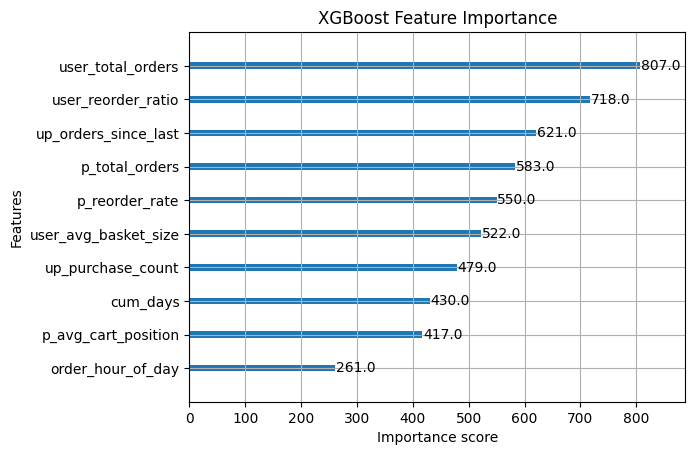

In [129]:

plt.figure(figsize=(10, 8))
plot_importance(xgb_model, max_num_features=10)
plt.title("XGBoost Feature Importance")
plt.show()

<Figure size 800x600 with 0 Axes>

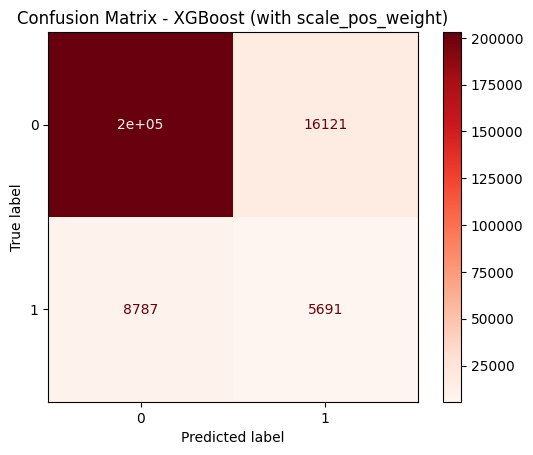

In [130]:

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Reds')
plt.title('Confusion Matrix - XGBoost (with scale_pos_weight)')
plt.show()

# **TASK B:**

# **Data Cleaning and Transformation**

In [132]:
if 'eval_set' not in data.columns:

    orders_subset = orders[['order_id', 'eval_set']]
    data = data.merge(orders_subset, on='order_id', how='left')

data = data[data['eval_set'].isin(['prior', 'train'])]

In [133]:

X_reg = data.drop(['days_since_prior_order', 'reordered', 'eval_set'], axis=1, errors='ignore')
y_reg = data['days_since_prior_order']

train_indices = data[data['eval_set'] == 'prior'].index
test_indices = data[data['eval_set'] == 'train'].index

X_train_reg = X_reg.loc[train_indices]
y_train_reg = y_reg.loc[train_indices]

X_test_reg = X_reg.loc[test_indices]
y_test_reg = y_reg.loc[test_indices]

print(f"Total Rows: {len(data)}")
print(f"Regression Train shape: {X_train_reg.shape}")
print(f"Regression Test shape: {X_test_reg.shape}")

Total Rows: 1136682
Regression Train shape: (1081676, 24)
Regression Test shape: (55006, 24)


In [134]:
X_train_numeric = X_train_reg.select_dtypes(include=[np.number])
X_test_numeric = X_test_reg.select_dtypes(include=[np.number])

X_train_numeric = X_train_numeric.fillna(0)
X_test_numeric = X_test_numeric.fillna(0)

scaler = StandardScaler()
X_train_reg_scaled = scaler.fit_transform(X_train_numeric)
X_test_reg_scaled = scaler.transform(X_test_numeric)

print("Fixed! Numerical features only are being used.")

Fixed! Numerical features only are being used.


# Ordinary Least Squares / Linear Regression

In [135]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

models_reg = {
    'OLS Linear Regression': LinearRegression(),
    'Lasso (L1)': Lasso(alpha=0.1),
    'Ridge (L2)': Ridge(alpha=1.0),
    'Elastic Net': ElasticNet(alpha=0.1, l1_ratio=0.5)
}

regression_results = []

for name, model in models_reg.items():
    model.fit(X_train_reg_scaled, y_train_reg)
    y_pred = model.predict(X_test_reg_scaled)

    mae = mean_absolute_error(y_test_reg, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred))
    r2 = r2_score(y_test_reg, y_pred)

    regression_results.append({'Model': name, 'MAE': mae, 'RMSE': rmse, 'R2': r2})

results_df = pd.DataFrame(regression_results)
display(results_df)

,Model,MAE,RMSE,R2
0,OLS Linear Regression,9.423672,10.701015,-0.035197
1,Lasso (L1),9.048948,10.227261,0.054434
2,Ridge (L2),9.423620,10.700913,-0.035177
3,Elastic Net,9.047868,10.247115,0.050759


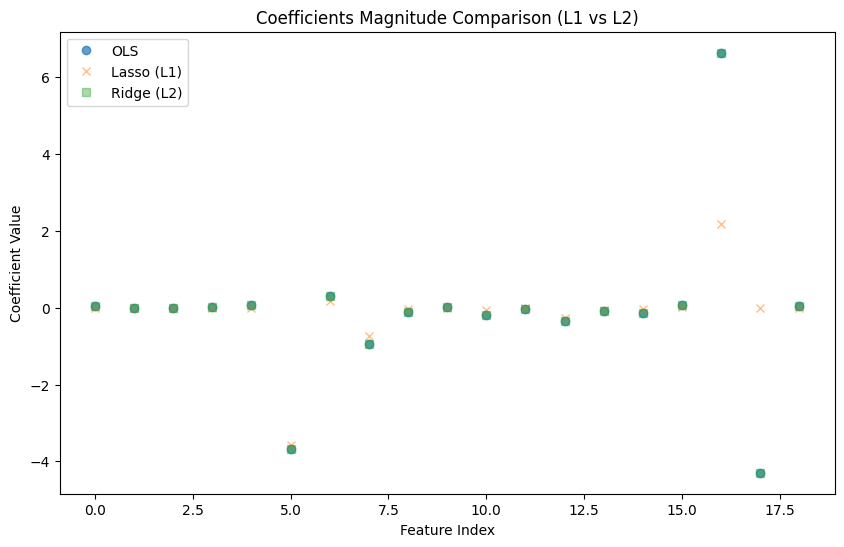

In [136]:
plt.figure(figsize=(10, 6))
plt.plot(models_reg['OLS Linear Regression'].coef_, alpha=0.7, linestyle='none', marker='o', label='OLS')
plt.plot(models_reg['Lasso (L1)'].coef_, alpha=0.5, linestyle='none', marker='x', label='Lasso (L1)')
plt.plot(models_reg['Ridge (L2)'].coef_, alpha=0.4, linestyle='none', marker='s', label='Ridge (L2)')
plt.title("Coefficients Magnitude Comparison (L1 vs L2)")
plt.xlabel("Feature Index")
plt.ylabel("Coefficient Value")
plt.legend()
plt.show()

# **• K-Nearest Neighbors Regressor (with different k and distance metrics)**


In [138]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

sample_size_knn = 5000
X_train_knn = X_train_reg_scaled[:sample_size_knn]
y_train_knn = y_train_reg[:sample_size_knn]
X_test_knn = X_test_reg_scaled[:1000]
y_test_knn = y_test_reg[:1000]

k_values = [3, 5, 11, 21]
metrics = ['euclidean', 'manhattan']
knn_results = []

for metric in metrics:
    for k in k_values:
        knn = KNeighborsRegressor(n_neighbors=k, metric=metric)
        knn.fit(X_train_knn, y_train_knn)

        y_pred = knn.predict(X_test_knn)

        mae = mean_absolute_error(y_test_knn, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test_knn, y_pred))
        r2 = r2_score(y_test_knn, y_pred)

        knn_results.append({
            'K': k,
            'Metric': metric,
            'MAE': mae,
            'RMSE': rmse,
            'R2': r2
        })

knn_df = pd.DataFrame(knn_results)
display(knn_df)

,K,Metric,MAE,RMSE,R2
0,3,euclidean,9.247000,11.256292,-0.168301
1,5,euclidean,9.022000,10.741821,-0.063947
2,11,euclidean,8.868818,10.402402,0.002228
3,21,euclidean,8.840428,10.327451,0.016554
4,3,manhattan,9.105000,11.059902,-0.127890
5,5,manhattan,8.826600,10.479403,-0.012598
6,11,manhattan,8.592363,10.043465,0.069896
7,21,manhattan,8.515858,9.895056,0.097181


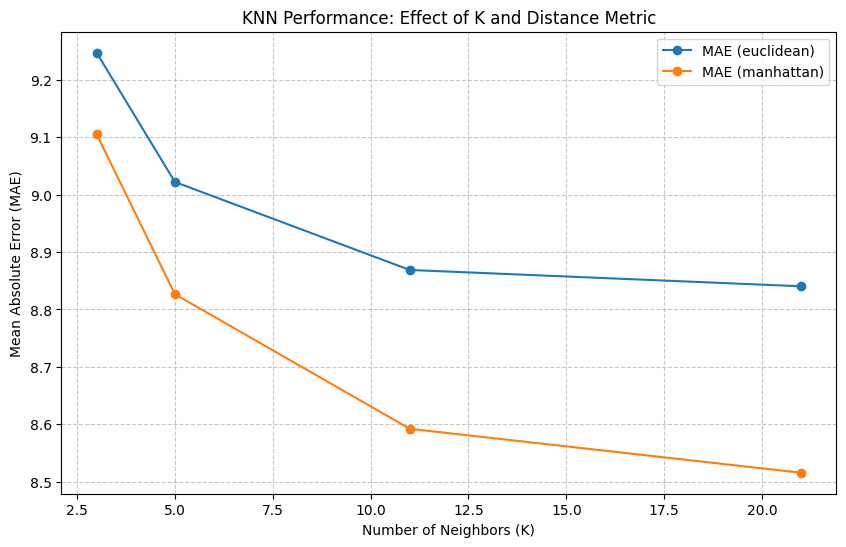

In [139]:
plt.figure(figsize=(10, 6))
for metric in metrics:
    subset = knn_df[knn_df['Metric'] == metric]
    plt.plot(subset['K'], subset['MAE'], marker='o', label=f'MAE ({metric})')

plt.title('KNN Performance: Effect of K and Distance Metric')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Mean Absolute Error (MAE)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()